In [1]:
%autosave 120
%load_ext Cython
import numpy as np
import matplotlib.pyplot as pl

np.set_printoptions(precision=2)
figsize(8, 8)

Autosaving every 120 seconds


In [2]:
DATADIR = "/Users/dsuess/Downloads/collinear/"
DATAFILE = DATADIR + "input10.txt"
MAXPOINTS = 500
RUNS = 5
xs, ys = np.loadtxt(DATAFILE, skiprows=1).T
slopemat = (ys[:, None] - ys[None, :]) / (xs[:, None] - xs[None, :])

In [3]:
%%cython

cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def find_colinear_brute(np.ndarray[double, ndim=2] sm,
                        double thresh=1e-6):
    result = []
    cdef int i, j, k, l
    
    for i in range(len(sm)):
        for j in range(i):
            for k in range(j):
                for l in range(k):
                    if ((sm[i, j] == sm[j, k]) and (sm[j, k] == sm[k, l])) \
                    or ((abs(sm[i, j] - sm[j, k]) < thresh)
                        and (abs(sm[j, k] - sm[k, l]) < thresh)):
                        result.append([i, j, k, l])
    return result

CPU times: user 19 µs, sys: 15 µs, total: 34 µs
Wall time: 31 µs


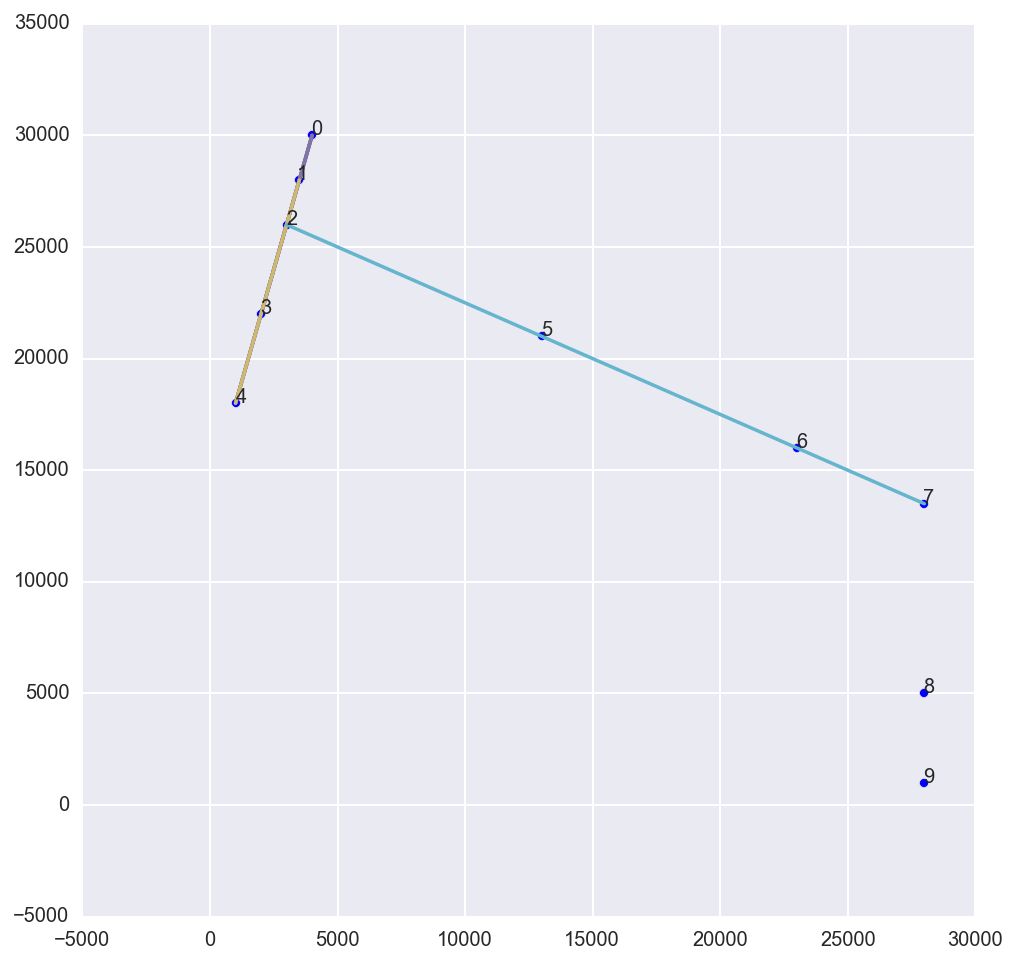

In [4]:
%time colinear = find_colinear_brute(slopemat)
pl.scatter(xs, ys)
for n, (x, y) in enumerate(zip(xs, ys)):
    pl.annotate(n, (x, y))

for points in colinear:
    pl.plot(xs[points], ys[points])

In [5]:
from glob import glob
from os.path import split
from tools.helpers import Progress
import timeit

paths = glob(DATADIR + 'input*.txt')
# Hacky^3!
counts = (int(split(path)[1][5:].split('.')[0]) for path in paths)
result = []

for n, path in Progress(zip(counts, paths)):
    if (n > MAXPOINTS) or (n < 4): continue
    
    xs_l, ys_l = np.loadtxt(path, skiprows=1).T
    slopemat_l = (ys_l[:, None] - ys_l[None, :]) \
        / (xs_l[:, None] - xs_l[None, :])
    runtime = timeit.timeit(lambda: find_colinear_brute(slopemat_l), 
                            number=RUNS) / RUNS
    result.append((n, runtime))

result_brute = np.asarray(result).T
result_brute.sort()

[==================================================]  29/29  


In [12]:
def find_colinear_fast(slopemat, min_points=4):
    lines = set()

    for m in xrange(len(slopemat)):
        slope = np.concatenate((slopemat[m, :m], slopemat[m, m + 1:]))
        # ~ N log(N)
        order = np.argsort(slope)
        invperm = np.argsort(order)
        # ~ N
        slope = slope[order]
        sel = (slope[1:] - slope[:-1]) < 1e-6
        # just to be sure we get all the infs
        sel += (slope[1:] == slope[:-1])

        it = enumerate(iter(sel))
        # ~ N
        for n, val in it:
            nstart = n
            while val:
                try:
                    n, val = it.next()
                except StopIteration:
                    n = n + 1
                    break
            # we have a connected region 
            if (n - nstart) >= min_points - 2:
                line = order[nstart:n + 1]
                line = np.concatenate(([m], line + (line >= m)))
                # this may be a complexity problem, if number of 
                # entries of line ~ N
                line.sort()
                lines.add(tuple(line))
    return lines

CPU times: user 901 µs, sys: 303 µs, total: 1.2 ms
Wall time: 986 µs


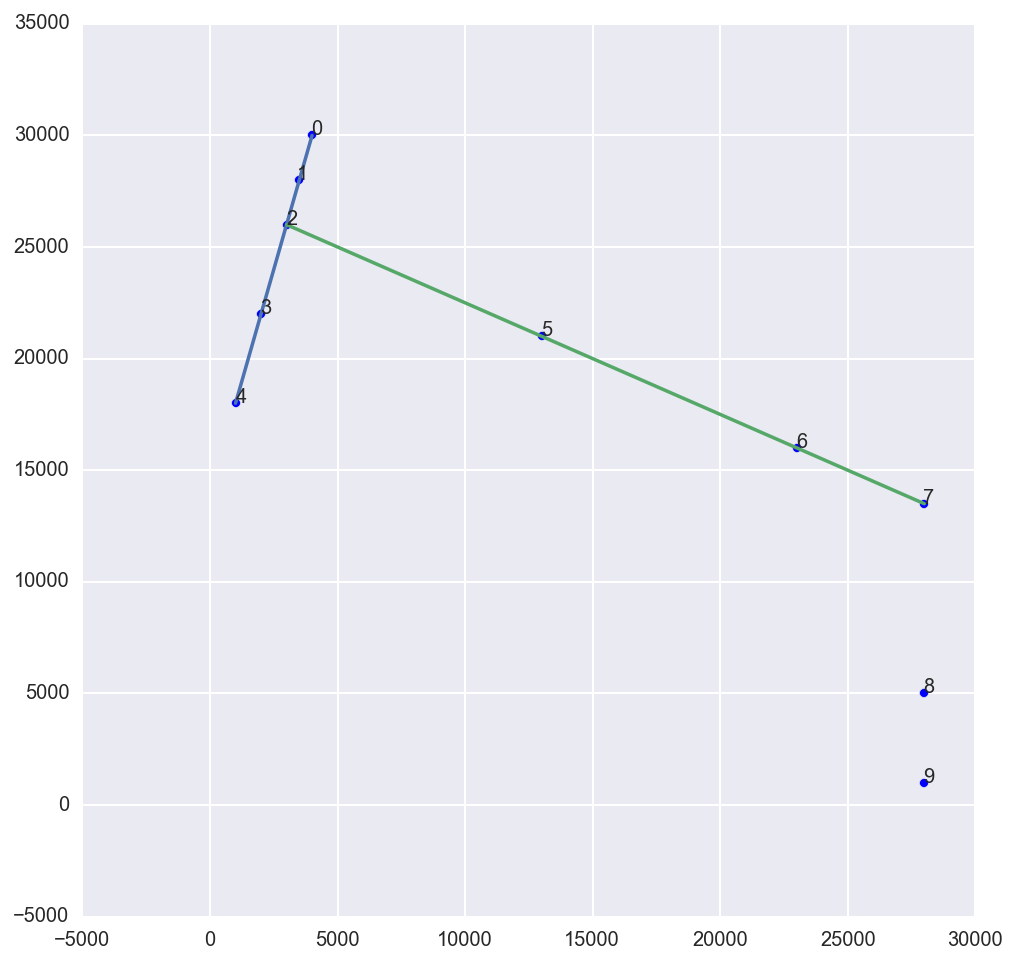

In [13]:
%time colinear = find_colinear_fast(slopemat)
pl.scatter(xs, ys)
for n, (x, y) in enumerate(zip(xs, ys)):
    pl.annotate(n, (x, y))

for points in colinear:
    pl.plot(xs[list(points)], ys[list(points)])

In [14]:
from glob import glob
from os.path import split
from tools.helpers import Progress
import timeit

paths = glob(DATADIR + 'input*.txt')
# Hacky^3!
counts = (int(split(path)[1][5:].split('.')[0]) for path in paths)
result = []

for n, path in Progress(zip(counts, paths)):
    if (n > MAXPOINTS) or (n < 4): continue
    
    xs_l, ys_l = np.loadtxt(path, skiprows=1).T
    slopemat_l = (ys_l[:, None] - ys_l[None, :]) \
        / (xs_l[:, None] - xs_l[None, :])
    runtime = timeit.timeit(lambda: find_colinear_fast(slopemat_l), 
                            number=RUNS) / RUNS
    result.append((n, runtime))

result_fast = np.asarray(result).T
result_fast.sort()

[==================================================]  29/29  


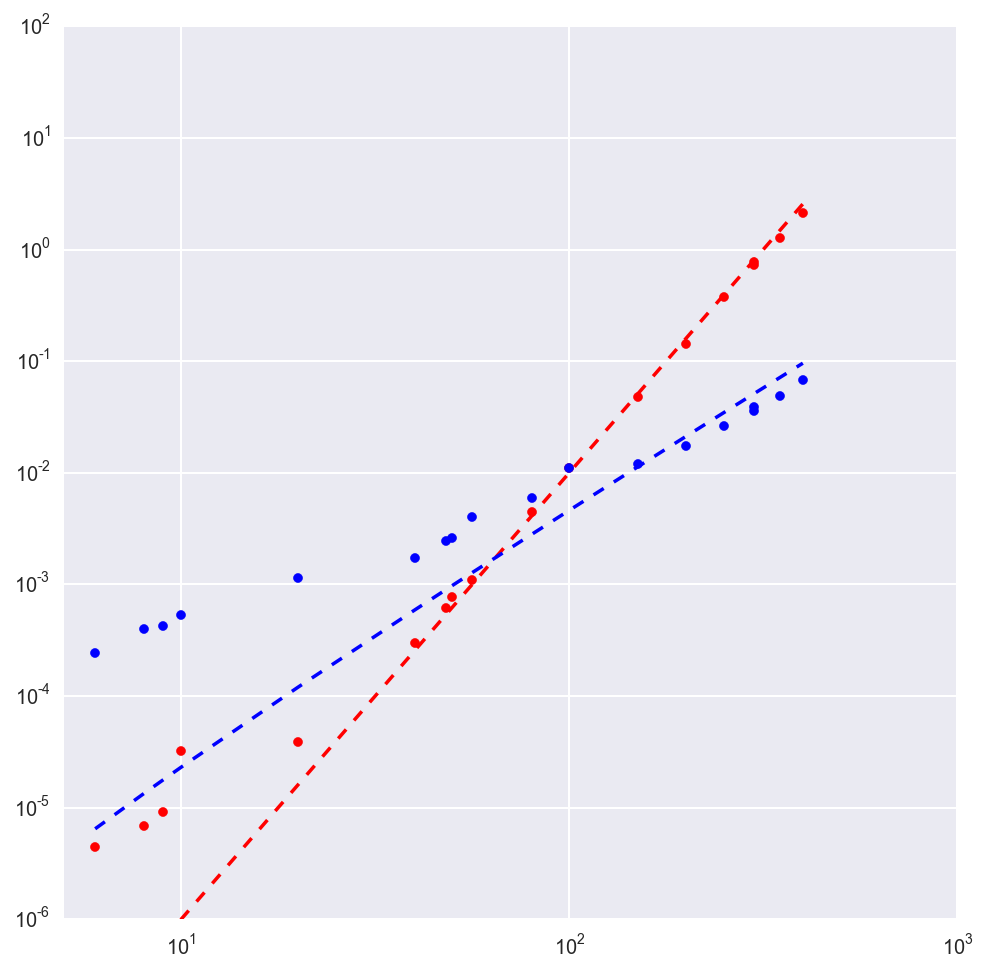

Total time brute: 5.45748667717 s
Total time fast: 0.277440404892 s


In [15]:
pl.scatter(result_brute[0], result_brute[1], color='r')
n4 = lambda n: n**4 * 1e-10
pl.plot(result_brute[0], n4(result_brute[0]) ,
        ls='--', color='r')

pl.scatter(result_fast[0], result_fast[1], color='b')
n2logn = lambda n: n**2 * np.log(n) * 1e-7
pl.plot(result_fast[0], n2logn(result_fast[0]),
        ls='--', color='b')

pl.xscale('log')
pl.yscale('log')

pl.axis([5e0, 1e3, 1e-6, 1e2])
pl.show()
print("Total time brute: {} s".format(np.sum(result_brute[1])))
print("Total time fast: {} s".format(np.sum(result_fast[1])))